In [57]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [58]:
# Lorenz 96 model
def Lorenz63(state, *args):
    sigma = args[0]
    beta  = args[1]
    rho   = args[2]
    x,y,z = state # Unpack the state vector
    f = np.zeros(3) # Create an empty vector to store the derivatives
    f[0] = sigma*(y-x)
    f[1] = x*(rho-z)-y
    f[2] = x*y - beta*z
    return f

# 4th order Runge-Kutta integrator
def RK4(rhs, state, dt, *args):
    k1 = rhs(state, *args)
    k2 = rhs(state + 0.5*dt*k1, *args)
    k3 = rhs(state + 0.5*dt*k2, *args)
    k4 = rhs(state + dt*k3, *args)
    return state + dt/6*(k1 + 2*k2 + 2*k3 + k4)

# Observation operators
def h(u):
    w = u
    return w

def Dh(u):
    n = len(u)
    D = np.eye(n)
    return D

In [59]:
# Ensemble Kalman Filters
def EnKF(ubi,w,ObsOp,JObsOp,R,B):
    
    # The analysis step for the (stochastic) ensemble Kalman filter 
    # with virtual observations

    n,N = ubi.shape # n is the state dimension and N is the size of ensemble
    m = w.shape[0] # m is the size of measurement vector

    # compute the mean of forecast ensemble
    ub = np.mean(ubi,1)    
    # compute Jacobian of observation operator at ub
    Dh = JObsOp(w)
    # compute Kalman gain
    D = Dh@B@Dh.T + R
    K = B @ Dh.T @ np.linalg.inv(D)
        
    
    wi = np.zeros([m,N])
    uai = np.zeros([n,N])
    for i in range(N):
        # create virtual observations
        wi[:,i] = w + np.random.multivariate_normal(np.zeros(m), R)
        # compute analysis ensemble
        uai[:,i] = ubi[:,i] + K @ (wi[:,i]-ObsOp(ubi[:,i]))
        
    # compute the mean of analysis ensemble
    ua = np.mean(uai,1)    
    # compute analysis error covariance matrix
    P = (1/(N-1)) * (uai - ua.reshape(-1,1)) @ (uai - ua.reshape(-1,1)).T
    return uai, P

# DEnKF function ------------------------------
def DEnKF(huxg_ens, huxg_obs, ObsFun, JObsFun, Cov_obs, Cov_model):
    """
    Analysis step of the Ensemble Kalman Filter (EnKF).
    
    huxg_ens: ndarray (n x N) - The ensemble matrix of model states (n is state size, N is ensemble size).
    huxg_obs: ndarray (m,) - The observation vector (m is measurement size).
    ObsFun: Function - Observation function.
    JObsFun: Function - Jacobian of the observation function.
    Cov_obs: ndarray (m x m) - Observation covariance matrix.
    Cov_model: ndarray (n x n) - Model covariance matrix.
    params: dict - Dictionary containing parameters like "m_obs".
    taper: ndarray (n x n) - Covariance taper matrix.
    
    Returns:
    analysis_ens: ndarray (n x N) - The updated ensemble after analysis.
    analysis_cov: ndarray (n x n) - The updated covariance after analysis.
    """
    n, N = huxg_ens.shape  # n is the state size, N is the ensemble size
    m = huxg_obs.shape[0]  # Measurement size (m)

    # Compute the ensemble mean
    huxg_ens_mean = np.mean(huxg_ens, axis=1)  # mean of model forecast ensemble
    
    # Compute the Jacobian of the observation operator
    Jobs = JObsFun(huxg_ens_mean)  # Jacobian of the observation operator
    
    # Compute the Kalman Gain
    KalGain = Cov_model @ Jobs.T @ np.linalg.inv(Jobs @ Cov_model @ Jobs.T + Cov_obs)

    # compute analysis of mean
    analysis_mean = huxg_ens_mean + KalGain @ (huxg_obs - ObsFun(huxg_ens_mean))

    # Initialize variables
    forecast_ens_ano = np.zeros((n, N))  # ensemble forecast anomalies
    analysis_ens_ano = np.zeros((n, N))   # Analysis ensemble anomailies

    # Perform the analysis for each ensemble member
    for i in range(N):
        #  forecast anomalies
        forecast_ens_ano[:,i] = huxg_ens[:,i] - huxg_ens_mean

        # analysis of anomalies
        analysis_ens_ano[:, i] = forecast_ens_ano[:, i] - (1/2)*KalGain@ObsFun(forecast_ens_ano[:, i])
    
    # Compute the analysis ensemble
    analysis_ens = analysis_ens_ano + analysis_mean.reshape(-1, 1)
    
    # Compute the analysis error covariance matrix
    analysis_cov = (1 / (N - 1)) * (analysis_ens_ano @ analysis_ens_ano.T)
    # analysis_cov = analysis_cov * taper  # Apply covariance tapering
    
    return analysis_ens, analysis_cov

# EnRSKF function ------------------------------
def EnRSKF(ubi,w,ObsOp,JObsOp,R,B):
    '''
    Reference: @article{tippett2003ensemble,
                        title={Ensemble square root filters},
                        author={Tippett, Michael K and Anderson, Jeffrey L and Bishop, Craig H and Hamill, Thomas M and Whitaker, Jeffrey S},
                        journal={Monthly weather review},
                        volume={131},
                        number={7},
                        pages={1485--1490},
                        year={2003},
                        publisher={American Meteorological Society}
                        }
    '''

    n,N = B.shape # n is the state dimension and N is the size of ensemble
    m = w.shape[0] # m is the size of measurement vector
    I = np.eye(N)

    # compute the mean of forecast ensemble
    ub = np.mean(ubi,axis=1)  
    d  = (w.reshape(-1,1) - ObsOp(ubi)) # compute the observation anomaly
    
    V  = ObsOp(B)      
    IN  = R + V@V.T  

    dxa = B@V.T@np.linalg.solve(IN,d) 
    xa  = ub.reshape(-1,1) + dxa

    Pat = I - V.T@np.linalg.solve(IN,V)

    U,S,V = np.linalg.svd(Pat) # Singular value decomposition

    Pat_sqrt = U @ np.diag(np.sqrt(S)) @ U.T

    XA = xa + B @ Pat_sqrt 
  
    return xa, XA

# EnTKF function ------------------------------
def EnTKF(ubi,w,ObsOp,JObsOp,R,B):
        
    # The analysis step for the (transform) ensemble Kalman filter
    '''
    Reference: @article{fairbairn2009comparison,
                        title={Comparison of the ensemble transform Kalman filter with the ensemble transform Kalman smoother},
                        author={Fairbairn, David},
                        journal={August), URL http://citeseerx. ist. psu. edu/viewdoc/download},
                        year={2009}
                        }
    ''' 

    n,N = B.shape # n is the state dimension and N is the size of ensemble
    I = np.eye(N)
    xb = np.mean(ubi,1) # compute the mean of forecast ensemble
    d = (w.reshape(-1,1) - ObsOp(ubi)) # compute the observation anomaly
    Q = ObsOp(B) # compute the observation operator

    proj_ens_space = Q.T @ np.linalg.solve(R,Q) # compute the projection matrix
    U,S,_ = np.linalg.svd(proj_ens_space) # singular value decomposition
    Pa_ens_inv = U @ np.diag(1/(S+1)) @ U.T # compute the inverse of the analysis error covariance matrix

    rhs = Q.T @np.linalg.solve(R,d)
    dxa = B @ Pa_ens_inv @ rhs # compute the analysis increment
    xa = xb.reshape(-1,1) + dxa # compute the analysis ensemble mean

    Pat_sqrt = U @np.diag(np.sqrt(1/(S+1))) @ U.T # compute the square root of the analysis error covariance matrix

    DXA_inc = B @ Pat_sqrt # compute the analysis ensemble increment
    XA = xa + DXA_inc # compute the analysis ensemble

    return xa, XA
        

In [60]:
sigma = 10
beta = 8/3
rho = 28
dt = 0.01
tm = 10
nt = int(tm/dt)
t = np.linspace(0,tm,nt+1)

#  initial conditions
u0True = np.array([1,1,1]) # True initial condition
np.random.seed(seed=1)
sig_m = 0.15
# R = sig_m**2 * np.eye(3) # observation error covariance matrix

dt_m = 0.2 # time interval between observations
tm_m = 2 # maximum time of observations
nt_m = int(tm_m/dt_m) # number of observations instants
ind_m = (np.linspace(int(dt_m/dt),int(tm_m/dt),nt_m)).astype(int) # indexes of observation instants
t_m = t[ind_m] # time instants of observations

print(ind_m)

[ 20  40  60  80 100 120 140 160 180 200]


In [61]:
#%% Application: Lorenz 63
########################### Data Assimilation ################################# 
u0b = np.array([2.0,3.0,4.0])
sig_b= 0.1
B = sig_b**2*np.eye(3)
Q = 0.0*np.eye(3)


nd = 3
ub = np.zeros([nd,nt+1])
ub[:,0] = u0b
ua = np.zeros([nd,nt+1])
ua[:,0] = u0b
n = nd #state dimension
m = nd #measurement dimension
# ensemble size
N = 30

R = sig_m**2 * np.eye(nd) # observation error covariance matrix

#time integration
uTrue = np.zeros([nd,nt+1])
uTrue[:,0] = u0True
km = 0
w = np.zeros([nd,nt_m])
for k in range(nt):
    time = k*dt
    uTrue[:,k+1] = RK4(Lorenz63,uTrue[:,k],dt,sigma,beta,rho)
    if (km<nt_m) and (k+1==ind_m[km]):
        w[:,km] = h(uTrue[:,k+1]) + np.random.normal(0,sig_m,[nd,])
        km = km+1

#initialize ensemble
uai = np.zeros([3,N])
for i in range(N):
    uai[:,i] = u0b + np.random.multivariate_normal(np.zeros(n), B)
    # uai[:,i] = u0b 
    # + np.random.normal(0,sig_b,[nd,])
print(u0b)


[2. 3. 4.]


In [ ]:
def EnKF_types(filter_type,uai=uai,ua=ua,ub=ub):
    km = 0  # Observation index

    # Main time loop
    for k in range(nt):
        # Forecast step for background trajectory (without correction)
        ub[:, k + 1] = RK4(Lorenz63, ub[:, k], dt, sigma, beta, rho)

        # Forecast step for the ensemble
        for i in range(N):  # Forecast ensemble
            uai[:, i] = RK4(Lorenz63, uai[:, i], dt, sigma, beta, rho) + np.random.multivariate_normal(np.zeros(n), Q)

        # Compute the mean of forecast ensemble
        ua[:, k + 1] = np.mean(uai, axis=1)

        # Compute forecast error covariance matrix (covariance of the ensemble)
        if filter_type == "EnKF" or filter_type == "DEnKF":
            B = (1 / (N - 1)) * (uai - ua[:, k + 1].reshape(-1, 1)) @ (uai - ua[:, k + 1].reshape(-1, 1)).T
        else:
            B = (1 / np.sqrt(N - 1)) * (uai - ua[:, k + 1].reshape(-1, 1))

        # Check if it is time for the analysis step (at observation times)
        if (km < nt_m) and (k + 1 == ind_m[km]):
            # Covariance matrix for measurement noise R can be computed here if needed
            # R = sig_m[k + 1]**2 * np.eye(nd)

            # Perform analysis step based on the chosen filter type
            if filter_type == "EnTKF":
                uai, B = EnTKF(uai, w[:, km], h, Dh, R, B)
            elif filter_type == "EnRSKF":
                uai, B = EnRSKF(uai, w[:, km], h, Dh, R, B)
            elif filter_type == "DEnKF":
                uai, B = DEnKF(uai, w[:, km], h, Dh, R, B)
            elif filter_type == "EnKF":
                uai, B = EnKF(uai, w[:, km], h, Dh, R, B)

            # Update the mean of analysis ensemble
            ua[:, k + 1] = np.mean(uai, axis=1)

            # Increment the observation index
            km += 1
    return ua, ub

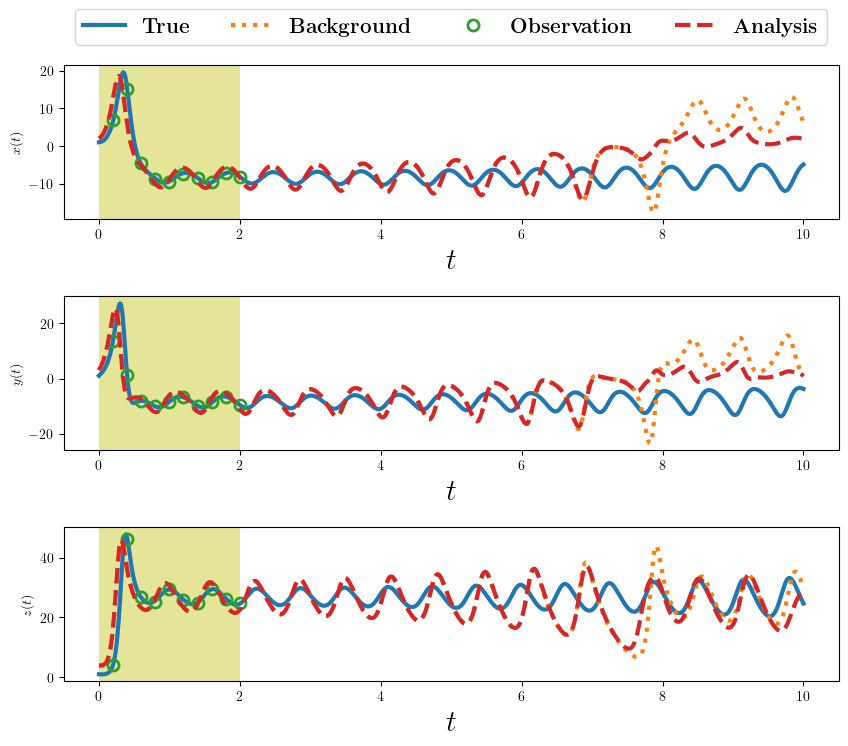

In [63]:
# ---plottings ---

# Define filter flags
filter_type = "EnKF"  # Options: 'EnKF', 'EnTKF', 'EnRSKF', 'DEnKF'
ens_analysis_mean, ens_back = EnKF_types(filter_type, uai, ua, ub)

plt.rcParams['text.usetex'] = True

font = {'family' : 'normal',
'weight' : 'bold',
'size' : 20}

# mpl.rc('font', **font)
fig, ax = plt.subplots(nrows=3,ncols=1, figsize=(10,8)) 
ax = ax.flat
for k in range(3):
    ax[k].plot(t,uTrue[k,:], label=r'\bf{True}', linewidth = 3) 
    ax[k].plot(t,ens_back[k,:], ':', label=r'\bf{Background}', linewidth = 3) 
    ax[k].plot(t[ind_m],w[k,:], 'o', fillstyle='none',  label=r'\bf{Observation}', markersize = 8, markeredgewidth = 2) 
    ax[k].plot(t,ens_analysis_mean[k,:], '--', label=r'\bf{Analysis}', linewidth = 3) 
    ax[k].set_xlabel(r'$t$',fontsize=22)
    ax[k].axvspan(0, tm_m, color='y', alpha=0.4, lw=0)
ax[0].legend(loc="center", bbox_to_anchor=(0.5,1.25),ncol =4,fontsize=15) 
ax[0].set_ylabel(r'$x(t)$')
ax[1].set_ylabel(r'$y(t)$')
ax[2].set_ylabel(r'$z(t)$')
fig.subplots_adjust(hspace=0.5)